In [1]:
from seagul.rl.ars.ars_pipe import ars
from seagul.nn import MLP
import torch
import matplotlib.pyplot as plt
from seagul.mesh import create_mesh, variation_dim, mesh_dim, create_box_mesh
import time
import copy
import gym
import torch

import xarray as xr
import numpy as np
import pandas as pd

import os

In [2]:
def identity(rews,obs,acts):
    return rews

def vardiv(rews, obs, acts):
    return rews/variation_dim(obs)

def varmul(rews, obs, acts):
    return rews*variation_dim(obs)

def rough_measure(x):
    d = torch.stack([x[t,:] - x[t-1,:] for t in range(1,x.shape[0])])
    return d.std()#$/(torch.abs(d.mean()))

def rmul(rews, obs, acts):
    return rews*rough_measure(obs)

def rdiv(rews, obs, acts):
    return rews/rough_measure(obs)

def pcastd(rews, obs, acts):
    pca = PCA()
    pca.fit((obs - obs.mean())/obs.std())
    return rews*pca.explained_variance_ratio_.std()


def mdim_mul(rews, obs, acts):
    m,_,_,_ = mesh_dim(obs)
    return m*rews

def mdim_div(rews, obs, acts):
    m,_,_,_ = mesh_dim(obs)
    return rews/m

def cdim_mul(rews, obs, acts):
    _,c,_,_ = mesh_dim(obs)
    return c*rews

def cdim_div(rews, obs, acts):
    _,c,_,_ = mesh_dim(obs)
    return rews/c


def madodiv(rews, obs, acts):
    return rews/variation_dim(obs, order=1)

def variodiv(rews, obs, acts):
    return rews/variation_dim(obs, order=2)

def radodiv(rews, obs, acts):
    return rews/variation_dim(obs, order=.5)



def do_rollout(env, policy, render=False):
    torch.autograd.set_grad_enabled(False)

    act_list = []
    obs_list = []
    rew_list = []

    dtype = torch.float32
    obs = env.reset()
    done = False
    cur_step = 0

    while not done:
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs_list.append(obs.clone())

        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())
        if render:
            env.render()
            time.sleep(.01)

        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)

        cur_step += 1

    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_length


def do_long_rollout(env, policy, ep_length):
    torch.autograd.set_grad_enabled(False)

    act_list = []
    obs_list = []
    rew_list = []

    dtype = torch.float32
    obs = env.reset()
    done = False
    cur_step = 0

    while cur_step < ep_length:
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs_list.append(obs.clone())

        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())

        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)

        cur_step += 1

    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_length

In [ ]:
## 2.6 -> 4.2 seed 
# data = torch.load("./datacdim2/Walker2d-v2.xr")


# policy_dict = data.policy_dict
# rews = data.rews/data.post_rews
# exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
# num_seeds = len(policy_dict[exp_names[0]])

# #policy_dict = torch.load("./data/mjw_longermul.pol_dict")
# #rews = torch.load("./data/mjw_longermul.data")

# means = rews.mean(dim="trial")
# stds = rews.std(dim="trial")

# plt.plot(means.T)
# plt.legend(exp_names)
# ci = stds

# for mean, c in zip(means, ci):
#     plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
# plt.title("\"True\" Reward")
# plt.figure()

# # for exp_name in exp_names:  
# #     plt.plot(rews.loc[exp_name].T)
# #     plt.title(exp_name)
# #     plt.figure()
    

In [ ]:

#2.6 -> 4.2 seed 
data = torch.load("./data_mcshdim4/Hopper-v2.xr")


policy_dict = data.policy_dict
rews = data.rews#/data.post_rews
post_rews = data.post_rews
ratio = data.rews/data.post_rews

exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
num_seeds = len(policy_dict[exp_names[0]])

#policy_dict = torch.load("./data/mjw_longermul.pol_dict")
#rews = torch.load("./data/mjw_longermul.data")

means = rews.mean(dim="trial")
stds = rews.std(dim="trial")

plt.plot(means.T)
plt.legend(exp_names)
ci = stds

for mean, c in zip(means, ci):
    plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
plt.title("\"True\" Reward")
plt.figure()



# for exp_name in exp_names:  
#     plt.plot(rews.loc[exp_name].T)
#     plt.title("True Rewards: " + exp_name)
#     plt.figure()
    
# for exp_name in exp_names:  
#     plt.plot(post_rews.loc[exp_name].T)
#     plt.title("Processed Rewards: " + exp_name)
#     plt.figure()
    
# for exp_name in exp_names:  
#     plt.plot(ratio.loc[exp_name].T)
#     plt.title("Ratio Rewards: " + exp_name)
#     plt.figure()
    

    


    

In [ ]:
data = torch.load("./data17/Walker2d-v2.xr")

policy_dict['identity'] = data.policy_dict['identity']
rews = data.rews#/data.post_rews
exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
num_seeds = len(policy_dict[exp_names[0]])

#policy_dict = torch.load("./data/mjw_longermul.pol_dict")
#rews = torch.load("./data/mjw_longermul.data")

means = rews.mean(dim="trial")
stds = rews.std(dim="trial")

plt.plot(means.T)
plt.legend(exp_names)
ci = stds

for mean, c in zip(means, ci):
    plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
plt.title("\"True\" Reward")
plt.figure()

# for exp_name in exp_names:  
#     plt.plot(rews.loc[exp_name].T)
#     plt.title(exp_name)
#     plt.figure()

In [ ]:
env_name = "Walker2d-v2"


num_experiments = 2
data = torch.load("./data_mcshdim3/Walker2d-v2.xr")
exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
num_seeds = len(policy_dict[exp_names[0]])

policy_dict = data.policy_dict


combined_curves =  rewards = xr.DataArray(np.zeros((num_experiments, num_seeds, 1000)),
                    dims = ("post", "trial", "epoch"),
                    coords = {"post": exp_names})


rews = data.rews#/data.post_rews
combined_curves[:, :, 750:] = rews


data = torch.load("./data17/Walker2d-v2.xr")
policy_dict['identity'] = data.policy_dict['identity']

rews = data.rews#/data.post_rews
combined_curves[:, :, :750] = rews.loc['identity']

means = combined_curves.mean(dim="trial")
stds = combined_curves.std(dim="trial")

plt.plot(means.T)
plt.legend(exp_names, loc='upper left')
ci = stds

for mean, c in zip(means, ci):
    plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
plt.title("Preprocessed Reward")
plt.figure()


<Figure size 432x288 with 0 Axes>

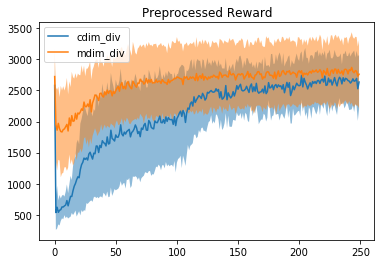

<Figure size 432x288 with 0 Axes>

In [6]:
env_name = "Hopper-v2"


num_experiments = 2
data = torch.load("./data_mcshdim4/Hopper-v2.xr")
policy_dict = data.policy_dict

exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
num_seeds = len(policy_dict[exp_names[0]])



combined_curves =  rewards = xr.DataArray(np.zeros((num_experiments, num_seeds, 1000)),
                    dims = ("post", "trial", "epoch"),
                    coords = {"post": exp_names})


rews = data.rews#/data.post_rews
combined_curves[:, :, 750:] = rews


data = torch.load("./data17/Hopper-v2.xr")
policy_dict['madodiv'] = data.policy_dict['madodiv']

# rews = data.rews#/data.post_rews
# combined_curves[:, :, :750] = rews.loc['madodiv']

# means = combined_curves.mean(dim="trial")
# stds = combined_curves.std(dim="trial")

means = rews.mean(dim='trial')
stds = rews.std(dim='trial')

plt.plot(means.T)
plt.legend(exp_names, loc='upper left')
ci = stds

for mean, c in zip(means, ci):
    plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
plt.title("Preprocessed Reward")
plt.figure()

In [ ]:
env_name = "HalfCheetah-v2"


num_experiments = 2
data = torch.load("./data_mcshdim4/HalfCheetah-v2.xr")
exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
num_seeds = len(policy_dict[exp_names[0]])

policy_dict = data.policy_dict


combined_curves =  rewards = xr.DataArray(np.zeros((num_experiments, num_seeds, 1000)),
                    dims = ("post", "trial", "epoch"),
                    coords = {"post": exp_names})


rews = data.rews#/data.post_rews
combined_curves[:, :, 750:] = rews


data = torch.load("./data17/HalfCheetah-v2.xr")
policy_dict['madodiv'] = data.policy_dict['madodiv']

rews = data.rews#/data.post_rews
combined_curves[:, :, :750] = rews.loc['madodiv']

means = combined_curves.mean(dim="trial")
stds = combined_curves.std(dim="trial")

plt.plot(means.T)
plt.legend(exp_names, loc='upper left')
ci = stds

for mean, c in zip(means, ci):
    plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
plt.title("Preprocessed Reward")
plt.figure()

running build_ext
Creating window glfw
tensor([3525.3623])
1.8442171899538993
3.7992049380885584


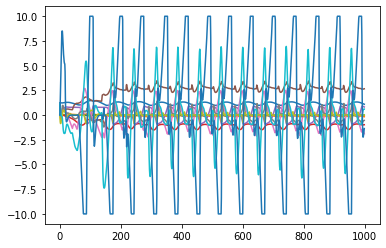

<Figure size 432x288 with 0 Axes>

In [8]:
seed = 0
ep_length = 10000
policy = policy_dict['madodiv'][seed]
env = gym.make(env_name)
%time o,a,r,_ = do_long_rollout(env, policy, ep_length= ep_length)
#o,a,r,l = do_rollout(env, policy, render=True)

plt.plot(o)
plt.figure()

target = o[200:]
#target = (target - policy.state_means)/policy.state_std
target = (target - target.mean(dim=0))/target.std(dim=0)

print(sum(r))
m,c,l,d = mesh_dim(target)
print(m)
print(c)

In [ ]:
# ==============
policy = policy_dict['mdim_div'][seed]
#%time o2,a2,r2,_ = do_long_rollout(env, policy, ep_length=ep_length)
o2,a2,r2,l2 = do_rollout(env, policy, render=True)
plt.plot(o2)
plt.figure()

target2 = o2[200:]
target2 = (target2 - policy.state_means)/policy.state_std
#target = (target - policy.state_means)/policy.state_std
 
print(sum(r2))
m2,c2,l2,d2 = mesh_dim(target2)
print(m2)
print(c2)

In [ ]:
# ==============
policy = policy_dict['cdim_div'][seed]
#%time o3,a3,r3,_ = do_long_rollout(env, policy, ep_length=ep_length)
o3,a3,r3,l3 = do_rollout(env, policy, render=True)
plt.plot(o3)

target3 = o3[200:]
target3 = (target3 - policy.state_means)/policy.state_std
#target = (target - policy.state_means)/policy.state_std

print(sum(r3))
m3,c3,l3,d3 = mesh_dim(target3)
print(m3)
print(c3)

In [ ]:
#plt.plot(np.log2(d3), np.log2(l3), 'x')
#plt.plot(np.log2(d), np.log2(l),'x')

#plt.figure()

#plt.plot(d2, l2, 'x')
#plt.plot(d, l, 'x')

#plt.figure()

mesh_size_upper = 4/5*o.shape[0]
mesh_sizes = l; d_vals = d
for i, msh in enumerate(mesh_sizes):
    if msh < mesh_size_upper:
        lin_begin = i
        break

xdata = np.log2(d_vals[lin_begin:-1])
ydata = np.log2(mesh_sizes[lin_begin:-1])

# find the largest slope
min_slope = 0
for i in range(len(ydata) - 2):
    slope = (ydata[i+1] - ydata[i]) / (xdata[i + 1] - xdata[i])
    if slope < min_slope:
        min_slope = slope
        min_i = i

plt.plot(xdata, ydata, 'x')
plt.plot([xdata[min_i], xdata[min_i+1]], [ydata[min_i], ydata[min_i+1]])

# ==============

mesh_size_upper = 4/5*o3.shape[0]
mesh_sizes = l2; d_vals = d2
for i, msh in enumerate(mesh_sizes):
    if msh < mesh_size_upper:
        lin_begin = i
        break
        
xdata = np.log2(d_vals[lin_begin:])
ydata = np.log2(mesh_sizes[lin_begin:])

# find the largest slope
min_slope = 0
for i in range(len(ydata) - 2):
    slope = (ydata[i+1] - ydata[i]) / (xdata[i + 1] - xdata[i])
    if slope < min_slope:
        min_slope = slope
        min_i = i


plt.plot(xdata[:-1], ydata[:-1], 'x')
plt.plot([xdata[min_i], xdata[min_i+1]], [ydata[min_i], ydata[min_i+1]])
plt.legend(['iden', 'iden steepest slope', 'cdiv', 'cdiv steepest slope'])
plt.title('log2(d) vs log2(mesh_size)')

# ==============

mesh_size_upper = 4/5*o3.shape[0]
mesh_sizes = l3; d_vals = d3
for i, msh in enumerate(mesh_sizes):
    if msh < mesh_size_upper:
        lin_begin = i
        break
        
xdata = np.log2(d_vals[lin_begin:])
ydata = np.log2(mesh_sizes[lin_begin:])

# find the largest slope
min_slope = 0
for i in range(len(ydata) - 2):
    slope = (ydata[i+1] - ydata[i]) / (xdata[i + 1] - xdata[i])
    if slope < min_slope:
        min_slope = slope
        min_i = i


plt.plot(xdata[:-1], ydata[:-1], 'x')
plt.plot([xdata[min_i], xdata[min_i+1]], [ydata[min_i], ydata[min_i+1]])
plt.title('log2(d) vs log2(mesh_size)')

plt.legend(['iden', 'iden steepest slope', 'mdiv', 'mdiv steepest slope', 'cdiv', 'cdiv steepest slope'])




In [ ]:
# plt.plot(np.log2(d2), np.array(l[:-1]) - np.array(l2),'x-')
# plt.title('log2(d) vs cdiv mesh size')
# plt.figure()

plt.plot(np.log2(d), l,'x-')
plt.plot(np.log2(d2), l2,'x-')
plt.plot(np.log2(d3), l3,'x-')
plt.legend(['id', 'mdiv', 'cdiv'])
plt.title("log(d) vs mesh size")

plt.figure()

plt.plot(d, l,'x-')
plt.plot(d2, l2,'x-')
plt.plot(d3, l3,'x-')
plt.legend(['id', 'mdiv', 'cdiv'])
plt.title("d vs mesh size")
plt.xlim([0,1])
plt.figure()


plt.plot(np.log2(d), l,'x-')
plt.plot(np.log2(d3), l3,'x-')
plt.legend(['id', 'cdiv'])
plt.title("log(d) vs mesh size")
#plt.plot(np.log2(d3), l3,'x-')

plt.figure()

plt.plot(d[:-2], np.array(l[:-2]) - np.array(l3),'x-')
plt.plot(d[:-2], np.array(l[:-2]) - np.array(l2),'x-')
plt.xlim([0,1])

#plt.plot(d3, l3,'x-')
#plt.legend(['id', 'mdiv', 'cdiv'])
#plt.title("d vs mesh size")
#plt.xlim([0,1])
#plt.figure()

In [ ]:
seed = 0
ep_length = 10000
policy = policy_dict['identity'][seed]
env = gym.make(env_name)
%time o,a,r,_ = do_long_rollout(env, policy, ep_length= ep_length)
#o,a,r,l = do_rollout(env, policy, render=True)

plt.plot(o)
plt.figure()

target = o[200:]
#target = (target - policy.state_means)/policy.state_std
target = (target - target.mean(dim=0))/target.std(dim=0)

print(sum(r))
m,c,l,d = mesh_dim(target)
print(m)
print(c)

# ==============
policy = policy_dict['mdim_div'][seed]
%time o2,a2,r2,_ = do_long_rollout(env, policy, ep_length=ep_length)
#o2,a2,r2,l2 = do_rollout(env, policy, render=True)
plt.plot(o2)
plt.figure()

target2 = o2[200:]
target2 = (target2 - policy.state_means)/policy.state_std
#target = (target - policy.state_means)/policy.state_std

print(sum(r2))
m2,c2,l2,d2 = mesh_dim(target2)
print(m2)
print(c2)

# ==============
policy = policy_dict['cdim_div'][seed]
%time o3,a3,r3,_ = do_long_rollout(env, policy, ep_length=ep_length)
#o3,a3,r3,l3 = do_rollout(env, policy, render=True)
plt.plot(o3)

target3 = o3[200:]
target3 = (target3 - policy.state_means)/policy.state_std
#target = (target - policy.state_means)/policy.state_std

print(sum(r3))
m3,c3,l3,d3 = mesh_dim(target3)
print(m3)
print(c3)

In [ ]:
from seagul.mesh import BylMesh


seed = 0
env = gym.make(env_name)

id_policy = policy_dict['identity'][seed]
id_sizes = []
id_mesh = BylMesh(.2)

for i in range(1000):
    obs,acts,rews,l = do_rollout(env, id_policy)
    obs = (obs - id_policy.state_means)/id_policy.state_std
    for o in obs:
        if o in id_mesh:
            id_mesh[o] += 1
        else:
            id_mesh[o] = 1

    if i % 100 == 0:      
        print(len(id_mesh))
    id_sizes.append(len(id_mesh))

print()
cd_policy = policy_dict['cdim_div'][seed]
cd_sizes = []
cd_mesh = BylMesh(.2)

for i in range(1000):
    obs,acts,rews,l = do_rollout(env, cd_policy)
    obs = (obs - cd_policy.state_means)/cd_policy.state_std
    for o in obs:
        if o in cd_mesh:
            cd_mesh[o] += 1
        else:
            cd_mesh[o] = 1

    if i % 100 == 0:      
        print(len(cd_mesh))
    cd_sizes.append(len(cd_mesh))
                 
#plt.plot(id_sizes)
#plt.plot(cd_sizes)

In [ ]:
x = [1000*i for i in range(len(id_sizes))]
plt.plot(x, id_sizes)
plt.plot(x, cd_sizes)
plt.legend(['identity', 'cdiv'])
plt.title('Mesh growth, no pertubations')
plt.xlabel('Points encountered')
plt.ylabel('Mesh size')

In [ ]:
x = [1000*i for i in range(len(cd_sizes))]
#xi = [1000*i for i in range(len(id_sizes))]

#plt.plot(xi, id_sizes)
plt.plot(x, cd_sizes, 'orange')
plt.legend(['cdiv'])
plt.title('Mesh growth, no pertubations')
plt.xlabel('Points encountered')
plt.ylabel('Mesh size')

In [ ]:
print()
cd_policy = policy_dict['cdim_div'][seed]
cd_sizes = []
cd_mesh = BylMesh(.2)

for i in range(25000):
    obs,acts,rews,l = do_rollout(env, cd_policy)
    obs = (obs - cd_policy.state_means)/cd_policy.state_std
    for o in obs:
        if o in cd_mesh:
            cd_mesh[o] += 1
        else:
            cd_mesh[o] = 1

    if i % 100 == 0:      
        print(len(cd_mesh))
    cd_sizes.append(len(cd_mesh))

In [ ]:
init_d = 1e-6
num_runs = 5; num_seeds=10
post_fns = [identity, cdim_div, mdim_div]
env = gym.make("Walker2d-v2")

msize1 = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": [fn.__name__ for fn in post_fns]})

msize2 = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": [fn.__name__ for fn in post_fns]})

msize4 = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": [fn.__name__ for fn in post_fns]})

mshdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": [fn.__name__ for fn in post_fns]})

cdims =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": [fn.__name__ for fn in post_fns]})

vdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": [fn.__name__ for fn in post_fns]})

mdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": [fn.__name__ for fn in post_fns]})

rdims =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": [fn.__name__ for fn in post_fns]})


for post_fn in post_fns:
    for i in range(num_seeds):
        for j in range(num_runs):
            policy = policy_dict[post_fn.__name__][i]
            o,a,r,l = do_long_rollout(env, policy, ep_length=1000)
            target = o[200:]
            target = (target - policy.state_means)/policy.state_std
            #target = (target - target.mean(dim=0))/target.std(dim=0)
        
            #m,w = create_mesh(target,init_d)
            #assert(len(m) == len(target))
                       
            mshdims.loc[post_fn.__name__,i,j], cdims.loc[post_fn.__name__,i,j] , _, _ = mesh_dim(target, init_d)
            mdims.loc[post_fn.__name__,i,j] = variation_dim(target)
            vdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=2)
            rdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=.5)

In [ ]:
print("madogram dimension")
for fn in post_fns:
    mean = mdims.mean(dim=('seed','run')).loc[fn.__name__].item()
    std = mdims.std(dim=('seed','run')).loc[fn.__name__].item()
    print(f"{fn.__name__} mean: {mean}, std: {std}")

In [ ]:
print("variogram dimension")
for fn in post_fns:
    mean = vdims.mean(dim=('seed','run')).loc[fn.__name__].item()
    std = vdims.std(dim=('seed','run')).loc[fn.__name__].item()
    print(f"{fn.__name__} mean: {mean}, std: {std}")
   

In [ ]:
print("radogram dimension")
for fn in post_fns:
    mean = rdims.mean(dim=('seed','run')).loc[fn.__name__].item()
    std = rdims.std(dim=('seed','run')).loc[fn.__name__].item()
    print(f"{fn.__name__} mean: {mean}, std: {std}")

In [ ]:
print("mesh dimension")
for fn in post_fns:
    mean = mshdims.mean(dim=('seed','run')).loc[fn.__name__].item()
    std = mshdims.std(dim=('seed','run')).loc[fn.__name__].item()
    print(f"{fn.__name__} mean: {mean}, std: {std}")

In [ ]:
print("cmesh dimension")
for fn in post_fns:
    mean = cdims.mean(dim=('seed', 'run')).loc[fn.__name__].item()
    std = cdims.std(dim=('seed', 'run')).loc[fn.__name__].item()
    print(f"{fn.__name__} mean: {mean}, std: {std}")

In [ ]:
print("vdim mean: \n", vdims.mean(dim='seed').to_series(), "\n")
print("vdim std: \n" , vdims.std(dim='seed').to_series(), "\n")

In [ ]:
print("mdim mean: \n", mdims.mean(dim='seed').to_series(), "\n")
print("mdim std: \n" , mdims.std(dim='seed').to_series(), "\n")

In [ ]:
print("cdim mean: \n", cdims.mean(dim='seed').to_series(), "\n")
print("cdim std: \n" , cdims.std(dim='seed').to_series(), "\n")

In [ ]:
from seagul.mesh import create_mesh_dict

In [ ]:
for post_name in ['identity' , 'vardiv' , 'rmul']: #seed = 10
    for seed in working_seeds[post_name]:
        for run in [0,1,2,3,4]:
            o,a,r,l = do_long_rollout(env,policy_dict[post_name][seed], ep_length=10000)

            #print("reward:", sum(r))
            #print("variation_dim: ", variation_dim(o))
            #print("roughness: ", rough_measure(o))
            #plt.plot(o)
            #plt.figure()
            #plt.plot(a)

            import scipy.io 
            import os

            o = np.array(o)
            a = np.array(a)
            r = np.array(r)
            os.makedirs(f"./k/env_{env_name}/post_{post_name}/seed_{seed}", exist_ok=True)
            scipy.io.savemat(f"./k/env_{env_name}/post_{post_name}/seed_{seed}/run_{run}.mat", mdict = {"obs":o, "act":a, "rew":r})

In [ ]:
def power_var(X, l, ord):
    # Implements the power variation, used for the variation fractal dimension
    return 1 / (2 * len(X) - l) * np.sum(np.linalg.norm(X[l:] - X[:-l],ord=ord))

def power_var(X, l, ord):
    diffs = X[l:] - X[:-l]
    norms = np.zeros(diffs.shape[0])
    for i,d in enumerate(diffs):
        norms[i] = np.linalg.norm(d,ord=1)
        
    return 1 / (2 * len(X) - l) * np.sum(norms)

def variation_dim(X, order=1):
    # Implements the order p variation fractal dimension from https://arxiv.org/pdf/1101.1444.pdf (eq 18)
    # order 1 corresponds to the madogram, 2 to the variogram, 1/2 to the rodogram
    return 2 - 1/(order*np.log(2))*(np.log(power_var(X, 2, order)) - np.log(power_var(X, 1, order)))

In [ ]:
def cdim_div(rews, obs, acts):
    _,c,_,_ = mesh_dim(obs)
    return rews/c

env_names = ["Walker2d-v2"]#,  "Hopper-v2", "HalfCheetah-v2"]#,  "linear_z2d-v0"]
post_fns = [cdim_div, identity]#, mdim_div]
#post_fns = [cdim_div]


torch.set_default_dtype(torch.float64)
num_experiments = len(post_fns)
num_seeds = 5
num_epochs = 250
n_workers = 12; n_delta = 60; n_top = 20; exp_noise=.025

init_data = torch.load("./data17/Walker2d-v2.xr")
init_policy_dict = init_data.policy_dict

save_dir = "./datacdim1/"
os.makedirs(save_dir)

import time
start = time.time()

env_config = {}
policy_dict[cdim_div.__name__] = [policy]

for env_name in env_names:
        env = gym.make(env_name, **env_config)
        in_size = env.observation_space.shape[0]
        out_size = env.action_space.shape[0]
        policy_dict =  {fn.__name__:[] for fn in post_fns}
        
        rewards = xr.DataArray(np.zeros((num_experiments, num_seeds, num_epochs)),
                    dims = ("post", "trial", "epoch"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

        post_rewards = xr.DataArray(np.zeros((num_experiments, num_seeds, num_epochs)),
                    dims = ("post", "trial", "epoch"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

        data = xr.Dataset(
            {"rews" : rewards,
            "post_rews" : post_rewards},
            coords = {"post": [fn.__name__ for fn in post_fns]},
            attrs  = {"policy_dict":policy_dict, "post_fns":post_fns, "env_name":env_name,
                      "hyperparams":{"num_experiments":num_experiments, "num_seeds":num_seeds, "num_epochs":num_epochs, "n_workers":n_workers, "n_delta":n_delta, "n_top":n_top, "exp_noise":exp_noise},
                      "env_config":env_config})             
            

        for post_fn in post_fns:
            for i in range(num_seeds):
                policy = init_policy_dict['identity'][i]
                policy, r_hist, lr_hist = ars(env_name, policy, num_epochs, n_workers=n_workers, n_delta=n_delta, n_top=n_top, exp_noise=exp_noise, postprocess=post_fn, env_config=env_config, zero_policy=False)
                print(f"{env_name}, {post_fn.__name__}, {i}, {time.time() - start}")
                data.policy_dict[post_fn.__name__].append(copy.deepcopy(policy))
                data.rews.loc[post_fn.__name__,i,:] = lr_hist
                data.post_rews.loc[post_fn.__name__,i,:] = r_hist

        torch.save(data, f"{save_dir}{env_name}.xr")


In [ ]:
o,a,r,l = do_long_rollout(env, policy, ep_length=10000)
target = o[200:]
target = (target - target.mean(dim=0))/target.std(dim=0)
m,c,d,l = mesh_dim(target)
print(m)
print(c)


In [ ]:
target = (obs - policy.state_means)/policy.state_std

mdim, cdim, mesh_sizes, d_vals = mesh_dim(target)

for i, m in enumerate(mesh_sizes):
    if m < mesh_size_upper:
        lin_begin = i
        break

xdata = np.log2(d_vals[lin_begin:])
ydata = np.log2(mesh_sizes[lin_begin:])

slopes = np.zeros(ydata.shape[0]-2)

for i in range(len(ydata) - 2):
    slopes[i] = (ydata[i+1] - ydata[i]) / (xdata[i + 1] - xdata[i])
    
print(mdim, cdim)
print(-np.min(slopes[:-1]))
print(-np.median(slopes[:-1]))

In [ ]:
plt.plot(xdata, ydata,'x')

In [ ]:
obs.shape